In [1]:
import awkward as ak
import numba
import numpy as np
import pandas as pd
import awkward as ak
import vector
vector.register_numba()
vector.register_awkward()
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
hep.style.use(hep.style.ROOT)

from importlib import reload

import numba
import spanet_predictions

In [2]:
@numba.njit
def assign_provenance_and_prob(t1pred, t2pred, hpred, 
                      t1prob, t2prob, hprob, njets):
    out = np.zeros((t1pred.shape[0], njets)) -1
    prob = np.zeros((t1pred.shape[0], njets, 3), dtype=np.float32)-np.float32(np.inf)
    
    #print(prob)
    for iev, (t1, t2, h, t1p, t2p, hp) in enumerate(zip(t1pred, t2pred, hpred, t1prob, t2prob, hprob)):
    
        if t1[0] == -2:
            prob_t1 = -np.inf
        else:
            prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
            
        if t2[0] == -2:
            prob_t2 = -np.inf
        else:
            prob_t2 = t2p[t2[0]]
            
        if h[0] == -2:
            prob_h = -np.inf
        else:
            prob_h = hp[h[0]][h[1]]
            
        
        # prob_t1 = t1p[t1[0]][t1[1]][t1[2]]
        # prob_t2 = t2p[t2[0]][t2[1]]
        # prob_h = hp[h[0]][h[1]]
        # print(prob_t1, prob_t2, prob_h)
        
        for i in t1: 
            out[iev][i] = 1
            prob[iev][i][0] = prob_t1
        for i in t2: 
            out[iev][i] = 2
            prob[iev][i][1] = prob_t2
        for i in h: 
            out[iev][i] = 3
            prob[iev][i][2] = prob_h

    return out, prob

In [3]:
basedir= "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_30_08_2023_v2/out_forTraining_sig_bkg"

In [4]:
os.listdir(basedir)

['all_jets_fullRun2_ttHTobb_forTraining_2018_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2017_v3.parquet',
 'all_jets_fullRun2_ttHTobb_forTraining_2016_PostVFP_v3.parquet']

In [4]:
df = ak.from_parquet(basedir)

RuntimeError: AppendRowGroups requires equal schemas.
This schema has 41 columns, other has 45

This error occurred while calling

    ak.from_parquet(
        '/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/sig_bkg_3'...
    )

In [ ]:
df.fields

In [ ]:
(jets,_,_,_,_,lep, met,_, weight) = ak.unzip(df)
jets = ak.with_name(jets, name="Momentum4D")
lep = ak.with_name(lep, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

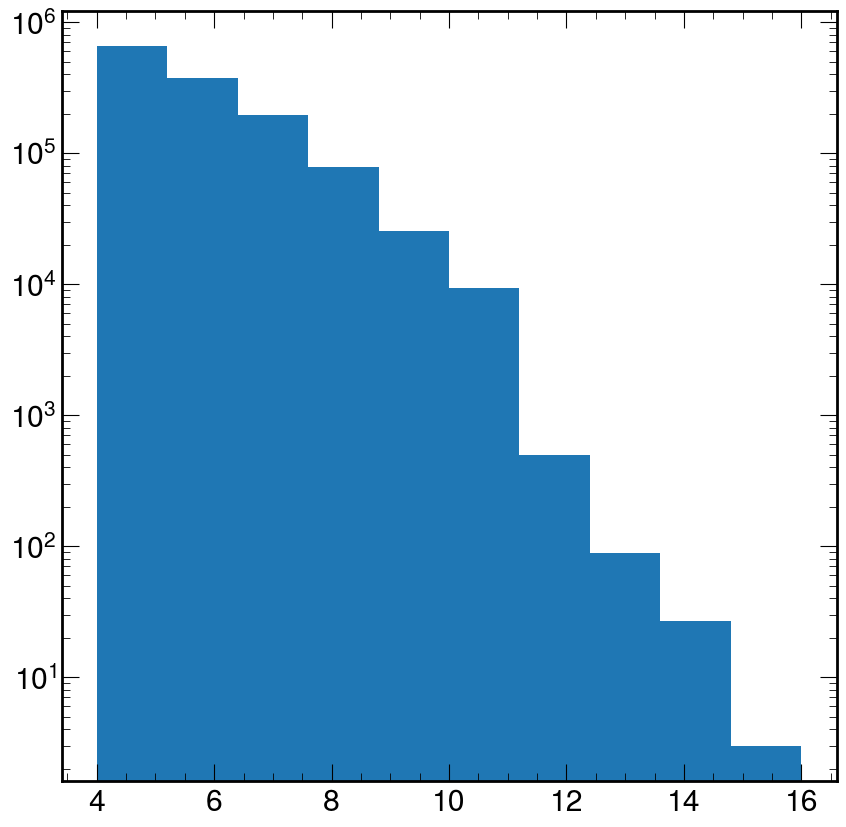

In [8]:
plt.hist(ak.num(jets))
plt.yscale("log")

In [6]:
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
sess_options = onnxruntime.SessionOptions()

sess_options.intra_op_num_threads = 20
sess_options.inter_op_num_threads = 2
#sess_options.intra_op_num_threads = 15
sess_options.execution_mode = onnxruntime.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL


session = onnxruntime.InferenceSession(
    "/work/dvalsecc/ttHbb/ttHbb_jets_partons_studies/SPANET/spanet.onnx", 
    sess_options = sess_options,
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
)

for input in session.get_inputs():
    print(f"{input.name}, {input.shape}")
    
for output in session.get_outputs():
    print(f"{output.name}, {output.shape}")

Source_data, ['batch_size', 'num_Source', 4]
Source_mask, ['batch_size', 'num_Source']
Met_data, ['batch_size', 'num_Met', 3]
Met_mask, ['batch_size', 'num_Met']
Lepton_data, ['batch_size', 'num_Lepton', 3]
Lepton_mask, ['batch_size', 'num_Lepton']
ht_data, ['batch_size', 'num_ht', 1]
ht_mask, ['batch_size', 'num_ht']
t1_assignment_log_probability, ['Reshapet1_assignment_log_probability_dim_0', 'Reshapet1_assignment_log_probability_dim_1', 'Reshapet1_assignment_log_probability_dim_2', 'Reshapet1_assignment_log_probability_dim_3']
t2_assignment_log_probability, ['Reshapet2_assignment_log_probability_dim_0', 'Reshapet2_assignment_log_probability_dim_1']
h_assignment_log_probability, ['Reshapeh_assignment_log_probability_dim_0', 'Reshapeh_assignment_log_probability_dim_1', 'Reshapeh_assignment_log_probability_dim_2']
t1_detection_log_probability, ['Logt1_detection_log_probability_dim_0']
t2_detection_log_probability, ['Logt1_detection_log_probability_dim_0']
h_detection_log_probability, [

2023-09-04 22:41:11.618771148 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [7]:
jets_padded = ak.fill_none(ak.pad_none(jets, 16, clip=True), {"btag":0., "pt":0., "phi":0., "eta":0.})

data = np.transpose(
    np.stack([
    ak.to_numpy(jets_padded.btag),
    ak.to_numpy(jets_padded.eta),
    ak.to_numpy(jets_padded.phi),
    np.log(1 + ak.to_numpy(jets_padded.pt))]),
    axes=[1,2,0]).astype(np.float32)

mask = ~ak.to_numpy(jets_padded.pt == 0)

met_data = np.stack([ak.to_numpy(met.eta),
                     ak.to_numpy(met.phi),
                     np.log(1+ ak.to_numpy(met.pt))], axis=1)[:,None,:].astype(np.float32)

lep_data = np.stack([ak.to_numpy(lep[:,0].eta),
                     ak.to_numpy(lep[:,0].phi),
                     np.log(1+ ak.to_numpy(lep[:,0].pt))], axis=1)[:,None,:].astype(np.float32)

ht_array = np.sum(ak.to_numpy(jets_padded.pt), axis=1)[:,None, None].astype(np.float32)

mask_global = np.ones(shape=[met_data.shape[0], 1]) == 1

In [8]:
batch_size = 512
nbatches = data.shape[0]// batch_size
print(f"{nbatches=}")

nbatches=7000


In [ ]:
from rich.progress import track

provenance = np.zeros((data.shape[0], 16))
prob_assignment = np.zeros((data.shape[0], 16, 3))


for i in track(range(nbatches), "Inference"):
    start = i*batch_size
    if i < (nbatches-1):
        stop = start+batch_size
    else:
        stop = len(data)
    outputs = session.run(input_feed={
        "Source_data": data[start:stop],
        "Source_mask": mask[start:stop],
        "Met_data": met_data[start:stop],
        "Met_mask": mask_global[start:stop],
        "Lepton_data": lep_data[start:stop],
        "Lepton_mask": mask_global[start:stop],
        "ht_data": ht_array[start:stop], 
        "ht_mask": mask_global[start:stop]},
        output_names=["t1_assignment_log_probability", "t2_assignment_log_probability",
                     "h_assignment_log_probability"]
        )
    preds_nomask = spanet_predictions.extract_predictions(outputs[0:3], masking=False)
    prov, prob = assign_provenance_and_prob(*preds_nomask, outputs[0], outputs[1], outputs[2],16)
    
    provenance[start:stop] = prov
    prob_assignment[start:stop]= prob

Output()

In [16]:
ak.with_name?

Signature: ak.with_name(array, name, highlevel=True, behavior=None)
Docstring:
Args:
    base: Data containing records or tuples.
    name (str): Name to give to the records or tuples; this assigns
        the `"__record__"` parameter.
    highlevel (bool): If True, return an #ak.Array; otherwise, return
        a low-level #ak.layout.Content subclass.
    behavior (None or dict): Custom #ak.behavior for the output array, if
        high-level.

Returns an #ak.Array or #ak.Record (or low-level equivalent, if
`highlevel=False`) with a new name. This function does not change the
array in-place.

The records or tuples may be nested within multiple levels of nested lists.
If records are nested within records, only the outermost are affected.

Setting the `"__record__"` parameter makes it possible to add behaviors
to the data; see #ak.Array and #ak.behavior for a more complete
description.
File:      ~/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/operations/structure.py

In [11]:
provenance.shape

(3584250, 16)

## Removing the padding

In [21]:
prob_assignment.shape

(3584250, 16, 3)

In [28]:
ak.to_parquet(ak.zip({"spanet_prob_assignment": ak.from_numpy(prob_assignment)}), basedir + "/spanet.parquet" )

In [27]:
provenance[3584249]

array([ 3.,  3.,  1.,  2., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.])

In [77]:
njets_good

<Array [5, 4, 4, 4, 6, 5, ... 7, 7, 5, 6, 5, 5] type='3584250 * int64'>

In [83]:
prob_assignment[5]

array([[0.        , 0.69542316, 0.23063106],
       [0.16833067, 0.        , 0.        ],
       [0.16833067, 0.        , 0.23063106],
       [0.16833067, 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [14]:
prob_assignment = np.exp(prob_assignment)


In [15]:
new_array = ak.zip(dict(zip(ak.fields(df), ak.unzip(df))) | {"prov_spanet": })

<Array [{jets: [, ... weight: 2.56e+03}] type='3584250 * {"jets": var * {"pt": f...'>

In [25]:
prob_assignment.shape

(1344266, 16, 3)

In [31]:
njets_good = ak.sum(mask, axis=1)

In [32]:
njets_good

<Array [5, 4, 4, 4, 6, 5, ... 7, 7, 5, 6, 5, 5] type='3584250 * int64'>

In [35]:
prob_assignment.shape

(3584250, 16, 3)

In [38]:
prob_assign_reshape = np.reshape(prob_assignment, (-1, 3) )

In [43]:
prob_masked = prob_assign_reshape[mask.flatten()]

In [47]:
prob_ak = ak.unflatten(ak.from_numpy(prob_masked), njets_good)

In [48]:
prob_ak

<Array [[[0, 0.664, 0], ... [0, 0, 0]]] type='3584250 * var * 3 * float64'>

In [50]:
ak.num(prob_ak)

<Array [5, 4, 4, 4, 6, 5, ... 7, 7, 5, 6, 5, 5] type='3584250 * int64'>

In [51]:
njets_good

<Array [5, 4, 4, 4, 6, 5, ... 7, 7, 5, 6, 5, 5] type='3584250 * int64'>

In [58]:
prob_ak[6].tolist()

[[0.0, 0.9990558011253297, 0.0],
 [0.0, 0.0, 0.48863674462167134],
 [0.34225123967733967, 0.0, 0.0],
 [0.34225123967733967, 0.0, 0.48863674462167134],
 [0.34225123967733967, 0.0, 0.0]]

TypeError: unhashable type: 'dict'

In [66]:
prob_ak

<Array [[[0, 0.664, 0], ... [0, 0, 0]]] type='3584250 * var * 3 * float64'>

In [96]:
df["prob_ak"] = prob_ak

df["jets"] = ak.zip( dict(zip(df.jets.fields,ak.unzip(df.jets))) |  {"prov_Thad": prob_ak[:,:,0],"prov_Tlep": prob_ak[:,:,1],"prov_H": prob_ak[:,:,2]})

In [99]:
df.jets.prov_Thad

<Array [[0, 0.444, 0.444, ... 0.426, 0, 0]] type='3584250 * var * float64'>

In [105]:
ak.to_parquet(df, basedir + "/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov.parquet")

In [104]:
prob_ak[:,:,0]

<Array [[0, 0.444, 0.444, ... 0.426, 0, 0]] type='3584250 * var * float64'>

<Array [True, True, True, ... True, True, True] type='3584250 * bool'>

In [122]:
df.jets[(njets_good >= 6)].prov_H

<Array [[0, 0, 0, 0.335, ... 0, 0, 0, 0]] type='1784384 * var * float64'>

(array([8.35185e+06, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.40000e+01,
        4.40000e+02, 2.56800e+03, 8.54000e+03, 2.17300e+04, 4.11400e+04,
        6.65880e+04, 9.42300e+04, 1.22450e+05, 1.46010e+05, 1.64298e+05,
        1.77554e+05, 1.85120e+05, 1.89626e+05, 1.91142e+05, 1.90004e+05,
        1.79784e+05, 1.65154e+05, 1.52148e+05, 1.38878e+05, 1.29014e+05,
        1.17910e+05, 1.09490e+05, 1.01984e+05, 9.47940e+04, 8.77440e+04,
        8.27880e+04, 7.72000e+04, 7.27660e+04, 6.97440e+04, 6.65360e+04,
        6.41260e+04, 6.30320e+04, 6.24400e+04, 6.45400e+04, 6.72220e+04]),
 array([0.        , 0.01249985, 0.02499969, 0.03749954, 0.04999938,
        0.06249923, 0.07499907, 0.08749892, 0.09999876, 0.11249861,
        0.12499845, 0.1374983 , 0.14999814, 0.16249799, 0.17499783,
        0.18749768, 0.19999752, 0.21249737, 0.22499721, 0.23749706,
        0.2499969 , 0.26249675, 0.27499659, 0.28749644, 0.29999628,
        0.31249613, 0.32499597, 0.33749582, 0.34999566, 0.36249551,
      

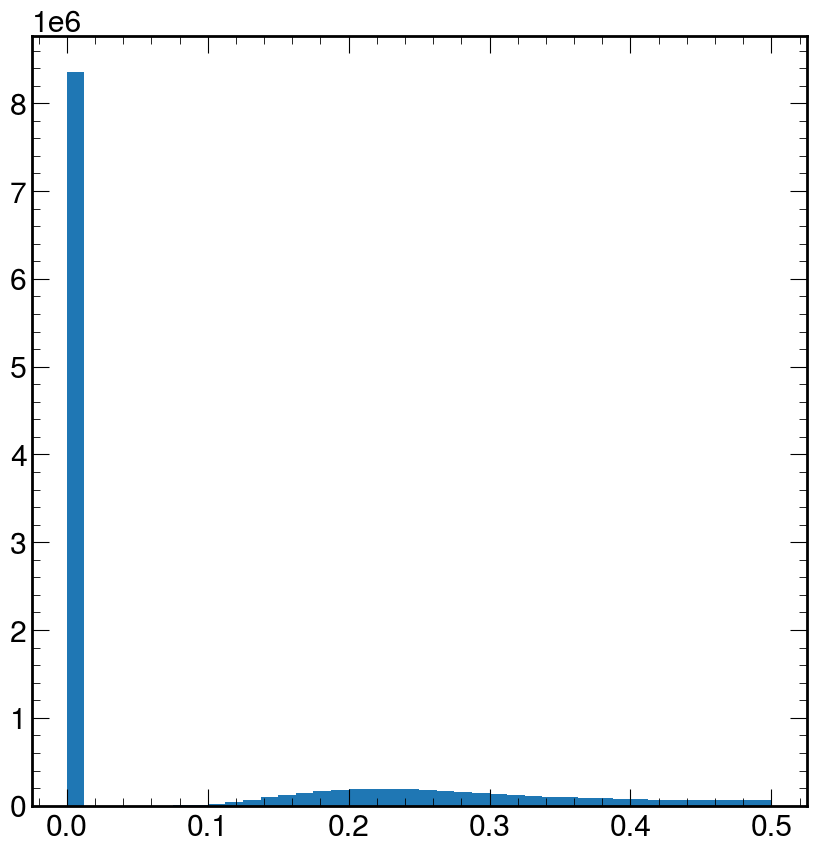

In [121]:
plt.hist(ak.flatten(df.jets[(njets_good >= 6)].prov_H), bins=40)

(array([9.0189e+05, 3.0000e+00, 7.8000e+01, 6.5000e+02, 2.7210e+03,
        7.1340e+03, 1.4481e+04, 2.3733e+04, 3.3990e+04, 4.4253e+04,
        5.3856e+04, 6.1846e+04, 6.8084e+04, 7.3658e+04, 7.6593e+04,
        7.8191e+04, 7.9870e+04, 7.9699e+04, 8.0602e+04, 8.2467e+04,
        8.0757e+04, 7.6304e+04, 7.2172e+04, 6.8407e+04, 6.5100e+04,
        6.2020e+04, 5.9703e+04, 5.7174e+04, 5.5444e+04, 5.3355e+04,
        5.2235e+04, 5.1278e+04, 4.9547e+04, 4.9307e+04, 4.9560e+04,
        5.0199e+04, 5.2067e+04, 5.5967e+04, 6.5861e+04, 9.3668e+04]),
 array([0.        , 0.01249889, 0.02499778, 0.03749667, 0.04999557,
        0.06249446, 0.07499335, 0.08749224, 0.09999113, 0.11249002,
        0.12498891, 0.13748781, 0.1499867 , 0.16248559, 0.17498448,
        0.18748337, 0.19998226, 0.21248115, 0.22498004, 0.23747894,
        0.24997783, 0.26247672, 0.27497561, 0.2874745 , 0.29997339,
        0.31247228, 0.32497118, 0.33747007, 0.34996896, 0.36246785,
        0.37496674, 0.38746563, 0.39996452, 0.

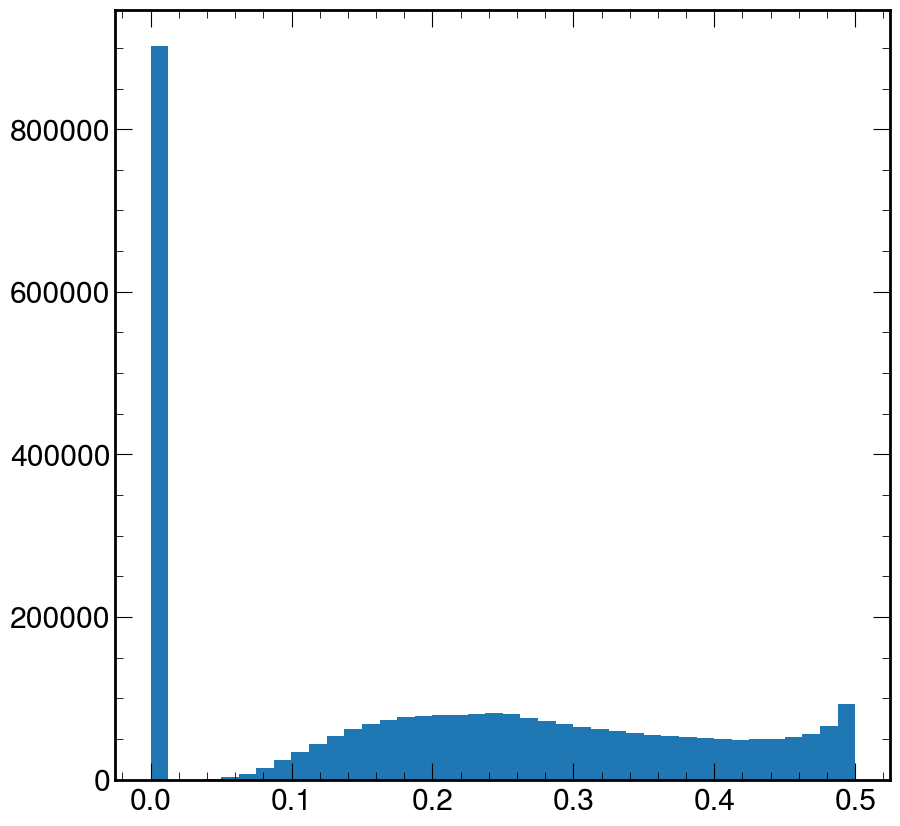

In [111]:
plt.hist(ak.flatten(df.jets[df.jets.prov==2].prov_Thad), bins=40)

(array([1.6696235e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.0000000e+00,
        7.3000000e+01, 5.5400000e+02, 2.8940000e+03, 1.0056000e+04,
        2.2428000e+04, 4.5967000e+04, 7.7955000e+04, 1.0391200e+05,
        1.2470800e+05, 1.4067600e+05, 1.5593600e+05, 1.7763600e+05,
        2.0003100e+05, 1.8590100e+05, 1.7232900e+05, 1.5908800e+05,
        1.4757500e+05, 1.3757800e+05, 1.2864100e+05, 1.1992100e+05,
        1.1355500e+05, 1.0669500e+05, 1.0229600e+05, 9.8007000e+04,
        9.4966000e+04, 9.3555000e+04, 9.3163000e+04, 9.5302000e+04,
        1.0002700e+05, 1.1189100e+05, 1.3816600e+05, 3.2275900e+05]),
 array([0.        , 0.02499999, 0.04999998, 0.07499996, 0.09999995,
        0.12499994, 0.14999993, 0.17499992, 0.1999999 , 0.22499989,
        0.24999988, 0.27499987, 0.29999986, 0.32499985, 0.34999983,
        0.37499982, 0.39999981, 0.4249998 , 0.44999979, 0.47499977,
        0.49999976, 0.52499975, 0.54999974, 0.

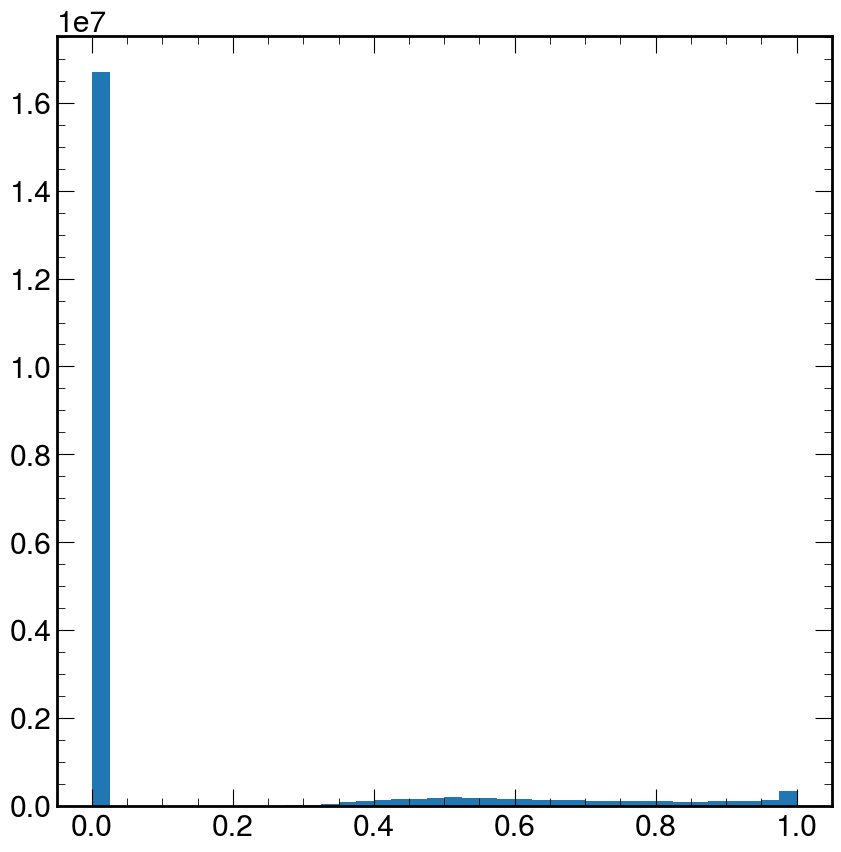

In [125]:
plt.hist(ak.flatten(df.jets.prov_Tlep), bins=40)

In [ ]:
ak.__version__